In [1]:
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np
import cv2
import mediapipe as mp
import torch

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")
torch.cuda.empty_cache()

Using cuda device


In [3]:
# custom point
POSE_CONNECTIONS_CUSTOM = [
    (3,0), (3,1), (3,15), (3,14), (3,17), (3,16), (3,2)
]

def getLandmark(rgb_img,detection_result, centroidKanan, centroidKiri, koorHelper):
  print(koorHelper)
  print(centroidKanan)
  pose_landmarks_list = detection_result.pose_landmarks
  annotated_image = np.copy(rgb_img)

  # Loop through the detected poses to visualize.
  # for idx in range(len(pose_landmarks_list)):
  for idx in range(len(pose_landmarks_list)):
    pose_landmarks = pose_landmarks_list[idx]
    print("panjang pose landmarks",len(pose_landmarks))

    # Draw the pose landmarks.
    pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    koorCentroidKanan = landmark_pb2.NormalizedLandmark(x=centroidKanan[0], y=centroidKanan[1], z=centroidKanan[2])
    koorCentroidKiri = landmark_pb2.NormalizedLandmark(x=centroidKiri[0], y=centroidKiri[1], z=centroidKiri[2])
    koorHelper = landmark_pb2.NormalizedLandmark(x=koorHelper[0], y=koorHelper[1], z=koorHelper[2])
    pose_landmarks_proto.landmark.extend([koorCentroidKanan, koorCentroidKiri, koorHelper])
    n = 0
    for landmark in pose_landmarks:
      # if(n==0 or n==20 or n==22 or n==18 or n==16 or n==21 or n==19 or n==15 or n==17):
        pose_landmarks_proto.landmark.extend(
          [landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z)]
         )
        n = n+1

  return pose_landmarks_proto


def draw_landmarks_on_image(rgb_img, pose_landmarks_proto):

  annotated_image = np.copy(rgb_img)
  solutions.drawing_utils.draw_landmarks(
      annotated_image,
      pose_landmarks_proto,
      POSE_CONNECTIONS_CUSTOM,
      # solutions.pose.POSE_CONNECTIONS,
      solutions.drawing_styles.get_default_pose_landmarks_style()
      )


  return annotated_image

In [4]:
# finding centroid

def findingCentroid(detection_result):
  kanan_1 = [detection_result.pose_landmarks[0][20].x, detection_result.pose_landmarks[0][20].y, detection_result.pose_landmarks[0][20].z]
  kanan_2 = [detection_result.pose_landmarks[0][22].x, detection_result.pose_landmarks[0][22].y, detection_result.pose_landmarks[0][22].z]
  kanan_3 = [detection_result.pose_landmarks[0][18].x, detection_result.pose_landmarks[0][18].y, detection_result.pose_landmarks[0][18].z]
  kanan_4 = [detection_result.pose_landmarks[0][16].x, detection_result.pose_landmarks[0][16].y, detection_result.pose_landmarks[0][16].z]
  avgKananY = (kanan_1[1] + kanan_2[1] + kanan_3[1] + kanan_4[1])/4
  avgKananX = (kanan_1[0] + kanan_2[0] + kanan_3[0] + kanan_4[0])/4
  avgKananZ = (kanan_1[2] + kanan_2[2] + kanan_3[2] + kanan_4[2])/4
  centroidKanan = [avgKananX, avgKananY, avgKananZ]

  kiri_1 = [detection_result.pose_landmarks[0][21].x, detection_result.pose_landmarks[0][21].y, detection_result.pose_landmarks[0][21].z]
  kiri_2 = [detection_result.pose_landmarks[0][19].x, detection_result.pose_landmarks[0][19].y, detection_result.pose_landmarks[0][19].z]
  kiri_3 = [detection_result.pose_landmarks[0][15].x, detection_result.pose_landmarks[0][15].y, detection_result.pose_landmarks[0][15].z]
  kiri_4 = [detection_result.pose_landmarks[0][17].x, detection_result.pose_landmarks[0][17].y, detection_result.pose_landmarks[0][17].z]
  avgKiriY = (kiri_1[1] + kiri_2[1] + kiri_3[1] + kiri_4[1])/4
  avgKiriX = (kiri_1[0] + kiri_2[0] + kiri_3[0] + kiri_4[0])/4
  avgKiriZ = (kiri_1[2] + kiri_2[2] + kiri_3[2] + kiri_4[2])/4
  centroidKiri = [avgKiriX, avgKiriY, avgKiriZ]

  koorHelper = [detection_result.pose_landmarks[0][0].x, detection_result.pose_landmarks[0][12].y, detection_result.pose_landmarks[0][0].z]

  return centroidKanan, centroidKiri, koorHelper


In [5]:
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands
from matplotlib.pyplot import imshow




In [6]:
def getFiturLandmark(img):
  base_options = python.BaseOptions(model_asset_path='pose_landmarker_heavy.task')
  options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=True)
  detector = vision.PoseLandmarker.create_from_options(options)
  img = img
  detection_result = detector.detect(img)
  centroidKanan, centroidKiri, koorHelper = findingCentroid(detection_result)
  landmarkData = getLandmark(img, detection_result, centroidKanan, centroidKiri, koorHelper)
  gambar = draw_landmarks_on_image(img.numpy_view(), landmarkData)
  imshow(cv2.cvtColor(gambar, cv2.COLOR_RGB2BGR))
  return landmarkData, detection_result

def getFiturJarak(landmarkData):
  fiturJarak = []
  for i in POSE_CONNECTIONS_CUSTOM:
    fiturJarak.append(np.linalg.norm(
      np.array((landmarkData.landmark[i[0]].x, landmarkData.landmark[i[0]].y, landmarkData.landmark[i[0]].z))
      -
      np.array((landmarkData.landmark[i[1]].x, landmarkData.landmark[i[1]].y, landmarkData.landmark[i[1]].z))
      ))
  # gambar = draw_landmarks_on_image(img.numpy_view(), landmarkData)
  # imshow(cv2.cvtColor(gambar, cv2.COLOR_RGB2BGR))

  return fiturJarak

def getFiturSudut(landmarkData):
  import math
  print(landmarkData.landmark[0].x)
  # dotA = [(detection_result.pose_landmarks[0][0].x - detection_result.pose_landmarks[0][3].x), (detection_result.pose_landmarks[0][0].y - detection_result.pose_landmarks[0][3].y)]
  # dotB =  [(detection_result.pose_landmarks[0][2].x - detection_result.pose_landmarks[0][3].x), (detection_result.pose_landmarks[0][2].y - detection_result.pose_landmarks[0][3].y)]
  # hasil = np.dot(dotA, dotB)
  # print(hasil)
  # norA = np.linalg.norm(dotA)
  # norB = np.linalg.norm(dotB)
  # sudut = math.degrees(math.acos(hasil/(norA*norB)))
  # print(sudut)

  n=0
  for i in POSE_CONNECTIONS_CUSTOM:
    if(n<len(POSE_CONNECTIONS_CUSTOM)):
      dotA = [(landmarkData.landmark[i[1]].x - landmarkData.landmark[3].x), (landmarkData.landmark[i[1]].y - landmarkData.landmark[3].y)]
      dotB =  [(landmarkData.landmark[2].x - landmarkData.landmark[3].x), (landmarkData.landmark[2].y - landmarkData.landmark[3].y)]
      norA = np.linalg.norm(dotA)
      norB = np.linalg.norm(dotB)
      hasil = np.dot(dotA, dotB)
      sudut = math.degrees(math.acos(hasil/(norA*norB)))
      print(sudut)
      n = n+1


#  ekstrak bentuk tangan
def mediapipeimg(image):
  with mp_hands.Hands(
    static_image_mode=True,
    max_num_hands=2,
    min_detection_confidence=0.5) as hands:
    results = hands.process(image)
    print('Handedness:', results.multi_handedness)



    image_height, image_width, _ = image.shape
    annotated_image = image.copy()

    landmark_tangan=[]
    for hand_landmarks in results.multi_hand_landmarks:
      # print('hand_landmarks:', hand_landmarks)
      # # landmark_tangan.append(hand_landmarks)
      # print(
      #     f'Index finger tip coordinates: (',
      #     f'{hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP].x * image_width}, '
      #     f'{hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP].y * image_height})'
      # )
      mp_drawing.draw_landmarks(
          annotated_image,
          hand_landmarks,
          mp_hands.HAND_CONNECTIONS,
          mp_drawing_styles.get_default_hand_landmarks_style(),
          mp_drawing_styles.get_default_hand_connections_style())



    return results, annotated_image

In [7]:

img = "../extractFrame/a lot/02124/25.jpg"
img = mp.Image.create_from_file(img)


[0.4961537718772888, 0.5212976932525635, -0.36859264969825745]
[0.3746882453560829, 0.6430556774139404, -0.13194221444427967]
panjang pose landmarks 33
[0.4677116558442005, 0.450452917453502, 0.5821992593718833, 0.4766116886283174, 0.8233424484646313, 0.7643550876259475, 0.26294565200805664]
0.3746882379055023
17.522883470204782
16.46021060764373
28.253378038256447
29.98018816491101
17.04489573604819
17.29849525936675
0.0


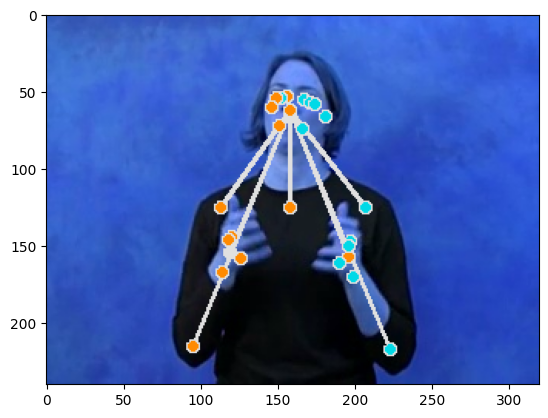

In [8]:
fiturLandmark, detection_landmark = getFiturLandmark(img)
fiturJarak = getFiturJarak(fiturLandmark)
print(fiturJarak)
getFiturSudut(fiturLandmark)



